# Capstone: Random Forest Analysis for Hospital Admission Duration Prediction

Rancel Hernandez

Student ID: 012218003

Mar 18, 2025

Research Question: Can a random forest regression model accurately predict patient admission duration based on demographic,  clinical measurements, and admission information from a publicly available critical care database?

Null Hypothesis: The random forest model cannot predict patient admission duration within an root mean squared error of 5 hours.

Alternative Hypothesis: The random forest model will be able to predict patient admission duration within a root mean squared error of 5 hours.

Context: This research explores predicting patient hospitalization admission duration to improve hospital resource allocation and care planning. An accurate model can help prioritize care for patients with longer expected stays, improve room assignments through better discharge forecasting, and optimize staff scheduling. Using a de-identified hospital dataset, a random forest model is trained with features available throughout the time of admission. The model can also help identify factors influencing hospital stays, potentially revealing opportunities to reduce hospitalization times and alleviate healthcare strain.

The goal is to develop a predictive model using random forest regression to accurately forecast
patient hospital length of stay based on demographic, clinical, and admission data from a public critical care
database. This project aims to improve healthcare resource allocation and patient care planning.

# Imports

In [1]:
# load and manage the data in a DataFrame
import pandas as pd

# numpy calculation methods
import numpy as np

# for categorical encoding
from sklearn.preprocessing import OneHotEncoder

# calculate the Z-scores to identify outliers
from scipy import stats

# visualize the data
import matplotlib.pyplot as plt

# visualize the model's feature importances
import seaborn as sns

# split the data and hyperparameter tuning with cross-validation
from sklearn.model_selection import train_test_split, GridSearchCV

# used to implement the random forest
from sklearn.ensemble import RandomForestRegressor

# evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score

# Load and Explore Data
- Load datasets
- Display head and shapes
- Remove duplicate admissions
- Count missing values per column

In [2]:
# model and variable names include suffixes based on the dataset used:
# _base for the base dataset, _vitals for the vitals dataset, _bp for the blood pressure dataset, and _pro for the procedures dataset

file_path = '/Users/rancelhernandez/Downloads/Capstone Files/critical_care_base1.csv'

# this is the base dataFrame that achieved the lowest RMSE ~57 hours
critical_care_base = pd.read_csv(file_path)

file_path = '/Users/rancelhernandez/Downloads/Capstone Files/critical_care_vitals1.csv'

# same columns as critical_care_base, 
# but includes ['max_bmi', 'min_bmi', 'weight', 'height']
critical_care_vitals = pd.read_csv(file_path)

file_path = '/Users/rancelhernandez/Downloads/Capstone Files/critical_care_bp1.csv'

# includes blood pressure as ['sbp', 'dbp', 'map']
critical_care_bp = pd.read_csv(file_path)

file_path = '/Users/rancelhernandez/Downloads/Capstone Files/critical_care_procedures1.csv'

# includes ['procedure_category'] for surgeries
critical_care_pro = pd.read_csv(file_path)

In [3]:
critical_care_base.head()

,patient_id,admission_id,admission_time,discharge_time,admission_type,admission_location,insurance,primary_language,marital_status,race,...,duration,age,gender,duration_hours,medication_delays,medication_duration,drg_severity,drg_mortality,medication_delays_hours,medication_duration_hours
0,19552401,20107427,2153-05-18 17:11:00,2153-05-19 15:15:00,EU OBSERVATION,EMERGENCY ROOM,Medicare,English,MARRIED,OTHER,...,22:04:00,63,M,22.0667,00:00:00,00:00:00,0,0,0.0,0.0
1,13017874,20324833,2154-07-14 00:10:00,2154-07-14 02:39:00,EW EMER.,EMERGENCY ROOM,Medicaid,English,SINGLE,UNKNOWN,...,02:29:00,29,M,2.4833,00:00:00,00:00:00,0,0,0.0,0.0
2,19204296,20376134,2155-09-15 22:17:00,2155-09-16 16:11:00,EU OBSERVATION,EMERGENCY ROOM,Medicare,English,WIDOWED,WHITE,...,17:54:00,82,F,17.9000,00:00:00,00:00:00,0,0,0.0,0.0
3,15311578,21197973,2127-09-30 05:27:00,2127-09-30 06:51:00,EU OBSERVATION,EMERGENCY ROOM,Private,English,SINGLE,WHITE,...,01:24:00,23,M,1.4000,00:00:00,00:00:00,0,0,0.0,0.0
4,19552401,21373123,2147-09-03 17:45:00,2147-09-04 12:08:00,AMBULATORY OBSERVATION,PROCEDURE SITE,Medicare,English,MARRIED,WHITE,...,18:23:00,63,M,18.3833,00:00:00,00:00:00,0,0,0.0,0.0


In [4]:
print("Base:", critical_care_base.shape)
print("Vitals:", critical_care_vitals.shape)
print("Blood Pressure:", critical_care_bp.shape)
print("Procedures:", critical_care_pro.shape)

Base: (544190, 26)
Vitals: (89669, 30)
Blood Pressure: (48928, 29)
Procedures: (162992, 27)


In [5]:
# all entries should have a unique admission id
if sum(critical_care_base['admission_id'].duplicated()) == 0:
    print('There are no duplicated values in the Base DataFrame.')
else:
    print('Duplicated entries detected in Base DataFrame.')
    print('Count:', critical_care_base.shape[0] - len(critical_care_base['admission_id'].unique()))

# do the same for the other DataFrames
if sum(critical_care_vitals['admission_id'].duplicated()) == 0:
    print('There are no duplicated values in Vitals DataFrame.')
else:
    print('Duplicated entries detected in Vitals DataFrame.')
    print('Count:', critical_care_vitals.shape[0] - len(critical_care_vitals['admission_id'].unique()))

if sum(critical_care_bp['admission_id'].duplicated()) == 0:
    print('There are no duplicated values in Blood Pressure DataFrame.')
else:
    print('Duplicated entries detected in Blood Pressure DataFrame.')
    print('Count:', critical_care_bp.shape[0] - len(critical_care_bp['admission_id'].unique()))

if sum(critical_care_pro['admission_id'].duplicated()) == 0:
    print('There are no duplicated values in Procedures DataFrame.')
else:
    print('Duplicated entries detected in Procedures DataFrame.')
    print('Count:', critical_care_pro.shape[0] - len(critical_care_pro['admission_id'].unique()))

Duplicated entries detected in Base DataFrame.
Count: 10
Duplicated entries detected in Vitals DataFrame.
Count: 1868
Duplicated entries detected in Blood Pressure DataFrame.
Count: 3730
Duplicated entries detected in Procedures DataFrame.
Count: 1


In [6]:
# create the duplicate masks
duplicate_mask_base = critical_care_base['admission_id'].duplicated()

In [7]:
# show the duplicated entries in the base DataFrame
critical_care_base[duplicate_mask_base]

,patient_id,admission_id,admission_time,discharge_time,admission_type,admission_location,insurance,primary_language,marital_status,race,...,duration,age,gender,duration_hours,medication_delays,medication_duration,drg_severity,drg_mortality,medication_delays_hours,medication_duration_hours
88971,11935209,29781872,2148-03-14 16:55:00,2148-03-17 12:20:00,URGENT,PHYSICIAN REFERRAL,Private,English,MARRIED,WHITE,...,2 days 19:25:00,37,F,67.4167,00:00:00,00:00:00,3,1,0.000000,0.000000
158063,10106244,26713233,2147-05-09 10:34:00,2147-05-12 13:43:00,DIRECT EMER.,PHYSICIAN REFERRAL,Private,English,SINGLE,WHITE,...,3 days 03:09:00,60,F,75.1500,29:14:00,114:12:00,4,4,29.233333,114.200000
205980,15443666,27961368,2168-12-30 23:30:00,2169-01-05 16:02:00,OBSERVATION ADMIT,EMERGENCY ROOM,Medicare,English,SINGLE,BLACK/AFRICAN AMERICAN,...,5 days 16:32:00,75,F,136.5333,29:18:00,106:12:00,0,0,29.300000,106.200000
208343,16433543,24062612,2159-01-26 01:10:00,2159-02-01 14:44:00,OBSERVATION ADMIT,EMERGENCY ROOM,Medicare,English,MARRIED,WHITE,...,6 days 13:34:00,71,M,157.5667,60:06:00,43:54:00,2,2,60.100000,43.900000
250950,18203312,29942652,2186-12-11 16:06:00,2186-12-17 17:30:00,ELECTIVE,PHYSICIAN REFERRAL,Medicare,English,MARRIED,WHITE,...,6 days 01:24:00,74,M,145.4000,71:54:00,39:52:00,2,1,71.900000,39.866667
277707,11055512,26746451,2169-10-04 12:16:00,2169-10-06 12:31:00,OBSERVATION ADMIT,EMERGENCY ROOM,Medicare,English,MARRIED,WHITE,...,2 days 00:15:00,76,M,48.2500,25:36:00,32:36:00,3,4,25.600000,32.600000
294092,13700703,20448599,2172-09-25 01:01:00,2172-10-03 13:25:00,OBSERVATION ADMIT,EMERGENCY ROOM,Private,English,MARRIED,WHITE,...,8 days 12:24:00,56,F,204.4000,80:38:00,16:26:00,1,1,80.633333,16.433333
364566,19242473,22747429,2157-10-05 22:39:00,2157-10-11 16:11:00,URGENT,TRANSFER FROM HOSPITAL,Medicare,English,WIDOWED,SOUTH AMERICAN,...,5 days 17:32:00,91,M,137.5333,27:26:00,90:16:00,3,3,27.433333,90.266667
468112,17464374,25425082,2178-10-27 20:00:00,2178-10-28 08:30:00,ELECTIVE,PHYSICIAN REFERRAL,No charge,English,SINGLE,UNKNOWN,...,12:30:00,22,F,12.5000,00:00:00,00:00:00,1,1,0.000000,0.000000
541923,16299919,26977065,2193-05-15 08:37:00,2193-05-17 16:03:00,OBSERVATION ADMIT,EMERGENCY ROOM,Medicare,English,WIDOWED,BLACK/AFRICAN AMERICAN,...,2 days 07:26:00,91,F,55.4333,34:04:00,65:44:00,0,0,34.066667,65.733333


In [8]:
# an example of duplicate admissions
critical_care_base[critical_care_base['admission_id'] == 26713233]

,patient_id,admission_id,admission_time,discharge_time,admission_type,admission_location,insurance,primary_language,marital_status,race,...,duration,age,gender,duration_hours,medication_delays,medication_duration,drg_severity,drg_mortality,medication_delays_hours,medication_duration_hours
158062,10106244,26713233,2147-05-09 10:34:00,2147-05-12 13:43:00,DIRECT EMER.,PHYSICIAN REFERRAL,Private,English,SINGLE,WHITE,...,3 days 03:09:00,60,F,75.15,29:14:00,114:12:00,4,4,29.233333,114.2
158063,10106244,26713233,2147-05-09 10:34:00,2147-05-12 13:43:00,DIRECT EMER.,PHYSICIAN REFERRAL,Private,English,SINGLE,WHITE,...,3 days 03:09:00,60,F,75.15,29:14:00,114:12:00,4,4,29.233333,114.2


In [9]:
# define the columns to consider when identifying duplicates
id_columns = ['admission_id']

# drop the duplicated values
critical_care_base = critical_care_base.drop_duplicates(subset=id_columns)
critical_care_vitals = critical_care_vitals.drop_duplicates(subset=id_columns)
critical_care_bp = critical_care_bp.drop_duplicates(subset=id_columns)
critical_care_pro = critical_care_pro.drop_duplicates(subset=id_columns)

In [10]:
# print the missing values in each DataFrame
print("Base:\n", critical_care_base.isna().sum())

print("\nVitals:\n", critical_care_vitals.isna().sum())

print("\nBlood Pressure:\n", critical_care_bp.isna().sum())

print("\nProcedures:\n", critical_care_pro.isna().sum())

Base:
 patient_id                       0
admission_id                     0
admission_time                   0
discharge_time                   0
admission_type                   0
admission_location               1
insurance                     9328
primary_language               767
marital_status               13566
race                             0
procedure_count                  0
diagnoses_count                  0
first_service                    0
medications_ordered              0
medications_given                0
readmission_status               0
duration                         0
age                              0
gender                           0
duration_hours                   0
medication_delays                0
medication_duration              0
drg_severity                     0
drg_mortality                    0
medication_delays_hours          0
medication_duration_hours        0
dtype: int64

Vitals:
 patient_id                      0
admission_id              

# Prepare Data
- Drop entries with missing values  
- Identify categorical features  
- Aggregate unique categories per feature  
- Create category mappings and groups  
- Aggregate key categorical features (race, language, service, admission type/location, procedure category)  
- Apply One-Hot Encoding  
- Display dataset shapes after encoding  

In [11]:
# drop the entries with missing values
critical_care_base.dropna(inplace=True)

critical_care_vitals.dropna(inplace=True)

critical_care_bp.dropna(inplace=True)

critical_care_pro.dropna(inplace=True)

In [12]:
# categorical features are type string(object)
string_columns = []

# excluded features
excluded_features = ['admission_time', 'discharge_time', 'duration', 'medication_delays', 'medication_duration']

# at each iteration, check if the current col is type object or an exluded feature
# the print the unique categories and save the current col to string_columns
for col in critical_care_base.columns:
    
    if critical_care_base[col].dtype == 'object' and col not in excluded_features:
        print(f'{col}: {list(critical_care_base[col].unique())}\n')
        string_columns.append(col)

# this cetegorical variable has integer based groups
# where for a range of ICD procedure codes 
# mappings found in the report
print(f'procedure_group: {list(critical_care_pro["procedure_category"].unique())}\n')

admission_type: ['EU OBSERVATION', 'EW EMER.', 'AMBULATORY OBSERVATION', 'ELECTIVE', 'URGENT', 'DIRECT OBSERVATION', 'DIRECT EMER.', 'OBSERVATION ADMIT', 'SURGICAL SAME DAY ADMISSION']

admission_location: ['EMERGENCY ROOM', 'PROCEDURE SITE', 'PHYSICIAN REFERRAL', 'PACU', 'TRANSFER FROM HOSPITAL', 'CLINIC REFERRAL', 'WALK-IN/SELF REFERRAL', 'AMBULATORY SURGERY TRANSFER', 'TRANSFER FROM SKILLED NURSING FACILITY', 'INTERNAL TRANSFER TO OR FROM PSYCH', 'INFORMATION NOT AVAILABLE']

insurance: ['Medicare', 'Medicaid', 'Private', 'Other', 'No charge']

primary_language: ['English', 'Russian', 'Chinese', 'Spanish', 'Portuguese', 'Thai', 'Italian', 'French', 'Kabuverdianu', 'Other', 'Amharic', 'Haitian', 'Persian', 'Arabic', 'Vietnamese', 'American Sign Language', 'Modern Greek (1453-)', 'Armenian', 'Bengali', 'Polish', 'Japanese', 'Khmer', 'Somali', 'Hindi', 'Korean']

marital_status: ['MARRIED', 'SINGLE', 'WIDOWED', 'DIVORCED']

race: ['OTHER', 'UNKNOWN', 'WHITE', 'BLACK/AFRICAN AMERICAN', 

In [13]:
# all the DataFrames contain the same deomgraphic information, 
# so the base will be used to create the mappings

# declare the race aggregation groups
asian = []
hispanic_latino = []
white = []
black = []
other_races = []

# for each unique race, group them based on the value
for race in critical_care_base['race'].unique():
    
    if "ASIAN" in race:
        asian.append(race)
        
    elif "HISPANIC" in race:
        hispanic_latino.append(race)
        
    elif "WHITE" in race:
        white.append(race)
        
    elif "BLACK" in race:
        black.append(race)
        
    else:
        other_races.append(race)

In [14]:
# do primary language based on top spoken languages in the United States
# this dataset is from a hospital in the United States
common_languages = ['English', 'Spanish', 'Chinese', 'Arabic', 'Vietnamese']

# subtract the common set from the unique set of languages to get the other languages
other_languages = list(set(critical_care_base['primary_language'].unique()) - set(common_languages))

print(other_languages)

['Portuguese', 'Hindi', 'Modern Greek (1453-)', 'Khmer', 'Somali', 'Thai', 'Italian', 'Bengali', 'Russian', 'French', 'Korean', 'Japanese', 'Other', 'Haitian', 'Polish', 'Armenian', 'Kabuverdianu', 'American Sign Language', 'Amharic', 'Persian']


In [15]:
# first_service aggregation groups
medical_services = ['MED', 'CMED', 'NMED', 'OMED']
surgical_services = ['SURG', 'NSURG', 'VSURG', 'TSURG', 'CSURG', 'PSURG']
specialized = ['ORTHO', 'ENT', 'GU', 'GYN', 'EYE', 'DENT', 'OBS']

# admission_type aggregation groups
urgent = ['URGENT', 'EW EMER.', 'DIRECT EMER.']
observation = ['EU OBSERVATION', 'OBSERVATION ADMIT', 'DIRECT OBSERVATION', 'AMBULATORY OBSERVATION']
planned = ['ELECTIVE', 'SURGICAL SAME DAY ADMISSION']

# admission_location aggregation groups
referrals = ['PHYSICIAN REFERRAL', 'CLINIC REFERRAL', 'WALK-IN/SELF REFERRAL']
external_transfers = ['TRANSFER FROM HOSPITAL', 'TRANSFER FROM SKILLED NURSING FACILITY']
internal_procedural_transfers = ['PACU', 'PROCEDURE SITE', 'INTERNAL TRANSFER TO OR FROM PSYCH', 'AMBULATORY SURGERY TRANSFER']

In [16]:
# use the aggregation groups to create mappings for the categories
race_mappings = {
    **{race: 'Asian' for race in asian},
    **{race: 'Hispanic/Latino' for race in hispanic_latino},
    **{race: 'White' for race in white},
    **{race: 'Black' for race in black},
    **{race: 'Other' for race in other_races}
}

language_mappings = {
    **{language: 'Other' for language in other_languages}
}

first_service_mappings = {
    **{code: 'Medical' for code in medical_services},
    **{code: 'Surgical' for code in surgical_services},
    **{code: 'Specialized' for code in specialized},
}

admission_type_mappings = {
    **{admission_type: 'Urgent' for admission_type in urgent},
    **{admission_type: 'Observation' for admission_type in observation},
    **{admission_type: 'Planned' for admission_type in planned}
}

admission_location_mappings = {
    **{admission_location: 'Referrals' for admission_location in referrals},
    **{admission_location: 'External Transfers' for admission_location in external_transfers},
    **{admission_location: 'Internal Procedural Transfers' for admission_location in internal_procedural_transfers}
}

In [17]:
# create a copy to transform the data
critical_care_aggregated_base = critical_care_base.copy(deep=True)

# use the mappings to aggregate the data
# missing values are those not in an aggregation group,
# so fill them in with the original value 
critical_care_aggregated_base['race'] = critical_care_base['race'].map(race_mappings).fillna(critical_care_base['race'])
critical_care_aggregated_base['first_service'] = critical_care_base['first_service'].map(first_service_mappings).fillna(critical_care_base['first_service'])
critical_care_aggregated_base['primary_language'] = critical_care_base['primary_language'].map(language_mappings).fillna(critical_care_base['primary_language'])
critical_care_aggregated_base['admission_type'] = critical_care_base['admission_type'].map(admission_type_mappings).fillna(critical_care_base['admission_type'])
critical_care_aggregated_base['admission_location'] = critical_care_base['admission_location'].map(admission_location_mappings).fillna(critical_care_base['admission_location'])

# do the same for the remaining DataFrames
# create a copy to transform the data
critical_care_aggregated_vitals = critical_care_vitals.copy(deep=True)

# use the mappings to aggregate the data
# missing values are those not in an aggregation group,
# so fill them in with the original value 
critical_care_aggregated_vitals['race'] = critical_care_vitals['race'].map(race_mappings).fillna(critical_care_vitals['race'])
critical_care_aggregated_vitals['first_service'] = critical_care_vitals['first_service'].map(first_service_mappings).fillna(critical_care_vitals['first_service'])
critical_care_aggregated_vitals['primary_language'] = critical_care_vitals['primary_language'].map(language_mappings).fillna(critical_care_vitals['primary_language'])
critical_care_aggregated_vitals['admission_type'] = critical_care_vitals['admission_type'].map(admission_type_mappings).fillna(critical_care_vitals['admission_type'])
critical_care_aggregated_vitals['admission_location'] = critical_care_vitals['admission_location'].map(admission_location_mappings).fillna(critical_care_vitals['admission_location'])

# create a copy to transform the data
critical_care_aggregated_bp = critical_care_bp.copy(deep=True)

# use the mappings to aggregate the data
# missing values are those not in an aggregation group,
# so fill them in with the original value 
critical_care_aggregated_bp['race'] = critical_care_bp['race'].map(race_mappings).fillna(critical_care_bp['race'])
critical_care_aggregated_bp['first_service'] = critical_care_bp['first_service'].map(first_service_mappings).fillna(critical_care_bp['first_service'])
critical_care_aggregated_bp['primary_language'] = critical_care_bp['primary_language'].map(language_mappings).fillna(critical_care_bp['primary_language'])
critical_care_aggregated_bp['admission_type'] = critical_care_bp['admission_type'].map(admission_type_mappings).fillna(critical_care_bp['admission_type'])
critical_care_aggregated_bp['admission_location'] = critical_care_bp['admission_location'].map(admission_location_mappings).fillna(critical_care_bp['admission_location'])

# create a copy to transform the data
critical_care_aggregated_pro = critical_care_pro.copy(deep=True)

# use the mappings to aggregate the data
# missing values are those not in an aggregation group,
# so fill them in with the original value 
critical_care_aggregated_pro['race'] = critical_care_pro['race'].map(race_mappings).fillna(critical_care_pro['race'])
critical_care_aggregated_pro['first_service'] = critical_care_pro['first_service'].map(first_service_mappings).fillna(critical_care_pro['first_service'])
critical_care_aggregated_pro['primary_language'] = critical_care_pro['primary_language'].map(language_mappings).fillna(critical_care_pro['primary_language'])
critical_care_aggregated_pro['admission_type'] = critical_care_pro['admission_type'].map(admission_type_mappings).fillna(critical_care_pro['admission_type'])
critical_care_aggregated_pro['admission_location'] = critical_care_pro['admission_location'].map(admission_location_mappings).fillna(critical_care_pro['admission_location'])

In [18]:
# confirm the mapping process
excluded_features = ['admission_time', 'discharge_time', 'duration', 'medication_delays', 'medication_duration']
for col in critical_care_aggregated_base.columns:
    if critical_care_aggregated_base[col].dtype == 'object' and col not in excluded_features:
        print(f'{col}: {list(critical_care_aggregated_base[col].unique())}\n')

admission_type: ['Observation', 'Urgent', 'Planned']

admission_location: ['EMERGENCY ROOM', 'Internal Procedural Transfers', 'Referrals', 'External Transfers', 'INFORMATION NOT AVAILABLE']

insurance: ['Medicare', 'Medicaid', 'Private', 'Other', 'No charge']

primary_language: ['English', 'Other', 'Chinese', 'Spanish', 'Arabic', 'Vietnamese']

marital_status: ['MARRIED', 'SINGLE', 'WIDOWED', 'DIVORCED']

race: ['Other', 'White', 'Black', 'Asian', 'Hispanic/Latino']

first_service: ['Medical', 'Surgical', 'Specialized', 'PSYCH', 'TRAUM']

gender: ['M', 'F']



In [19]:
# create a copy for the One-Hot encoding
# use the procedure DataFrame since it has all the cetegorical varibles plus procedure_category
critical_care_transformed_base = critical_care_aggregated_pro.copy(deep=True)

# append procedure_category to string_columns to ensure it gets encoded
string_columns.append('procedure_category')

# create and fit all encoders on the main DataFrame
encoders = {}
for col in string_columns:
    
    # create an encoder for each column
    encoders[col] = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
    
    # fit on the base DataFrame
    encoders[col].fit(critical_care_transformed_base[col].values.reshape(-1, 1))

# this function transforms a DataFrame using our fitted encoders
def transform_df(df):

    # create a copy to use for the transformations
    df_copy = df.copy(deep=True)
    
    for col in string_columns:
        
        # should avoid errors where procedure_category is called for the other DataFrames
        if col in df_copy.columns:
            # transform using the fitted encoder
            encoded_values = encoders[col].transform(df_copy[col].values.reshape(-1, 1))
            
            # create a DataFrame with encoded values
            feature_names = encoders[col].get_feature_names_out([col])
            transformed_values = pd.DataFrame(encoded_values, columns=feature_names, index=df_copy.index)
            
            # add it to the DataFrame and drop original column
            df_copy = pd.concat([df_copy, transformed_values], axis=1)
            df_copy = df_copy.drop(col, axis=1)
            
    return df_copy

# transform all DataFrames
critical_care_transformed_base = transform_df(critical_care_aggregated_base)
critical_care_transformed_vitals = transform_df(critical_care_aggregated_vitals)
critical_care_transformed_bp = transform_df(critical_care_aggregated_bp)
critical_care_transformed_pro = transform_df(critical_care_aggregated_pro)

In [20]:
# the number of columns increased from 20 to 54
print("Base Number of original columns:", critical_care_base.shape[1])
print("Base Number of columns after encoding:", critical_care_transformed_base.shape[1])

print("Vitals Number of original columns:", critical_care_vitals.shape[1])
print("Vitals Number of columns after encoding:", critical_care_transformed_vitals.shape[1])

print("Blood Pressure Number of original columns:", critical_care_bp.shape[1])
print("Blood Pressure Number of columns after encoding:", critical_care_transformed_bp.shape[1])

print("Procedures Number of original columns:", critical_care_pro.shape[1])
print("Procedures Number of columns after encoding:", critical_care_transformed_pro.shape[1])

# save the number of total entries per DataFrame to calculate the total number of outliers later
cct_entries = critical_care_transformed_base.shape[0]
ccv_entries = critical_care_transformed_vitals.shape[0]
ccbp_entries = critical_care_transformed_bp.shape[0]
ccpro_entries = critical_care_transformed_pro.shape[0]

Base Number of original columns: 26
Base Number of columns after encoding: 45
Vitals Number of original columns: 30
Vitals Number of columns after encoding: 49
Blood Pressure Number of original columns: 29
Blood Pressure Number of columns after encoding: 48
Procedures Number of original columns: 27
Procedures Number of columns after encoding: 61


# Feature Analysis: Distributions, Statistics, and Outliers
- Identify the numeric features and calculate their Z-scores
- Create a mask for outliers (|Z| > 3) 
- Display statistics excluding outliers  
- Display statistics of outliers  
- Visualize the distribution of the Z-scores using a histogram
- Remove the outliers
- Show distribution of aggregated categorical features
- Drop categories that are extremely rare.

Procedure_count
Count: 510831
Min: 0
Max: 8
Mean: 1.3
Std: 1.79

Outliers:
Count: 10928
Min: 9
Max: 41
Mean: 12.55
Std: 4.55


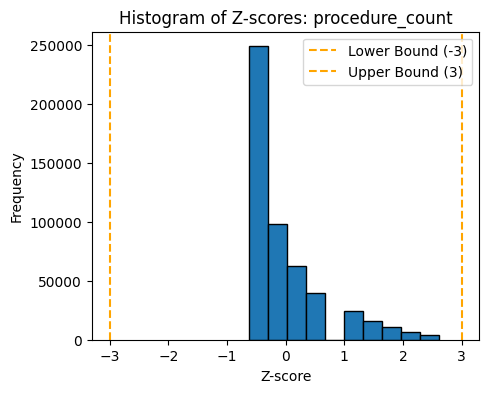

Diagnoses_count
Count: 515280
Min: 0
Max: 34
Mean: 11.35
Std: 7.06

Outliers:
Count: 6479
Min: 35
Max: 57
Mean: 37.54
Std: 1.57


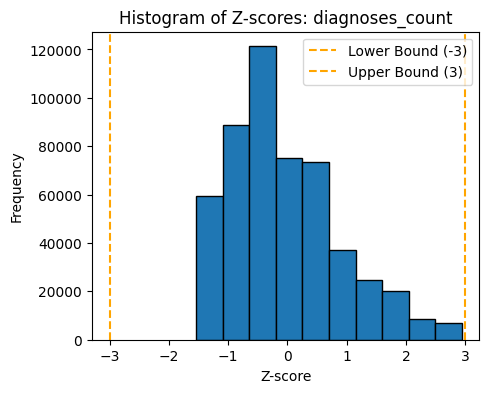

Medications_ordered
Count: 514085
Min: 0
Max: 719
Mean: 55.6
Std: 104.92

Outliers:
Count: 7674
Min: 720
Max: 27890
Mean: 1320.58
Std: 911.25


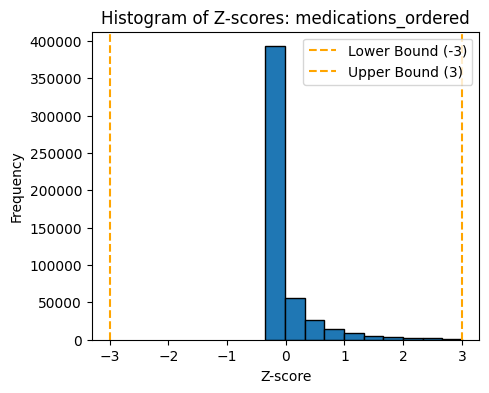

Medications_given
Count: 514108
Min: 0
Max: 500
Mean: 38.76
Std: 73.25

Outliers:
Count: 7651
Min: 501
Max: 19538
Mean: 914.42
Std: 638.69


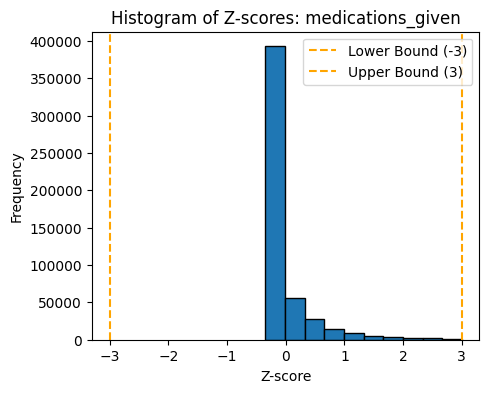

Age
Count: 521759
Min: 18
Max: 91
Mean: 57.1
Std: 18.84


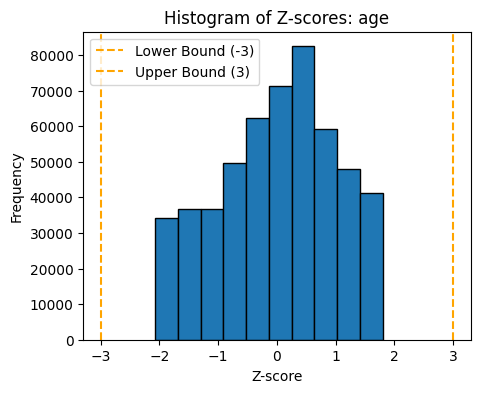

Duration_hours
Count: 512600
Min: 0.0
Max: 622.4167
Mean: 97.18
Std: 100.52

Outliers:
Count: 9159
Min: 622.4333
Max: 12373.5
Mean: 1001.22
Std: 523.37


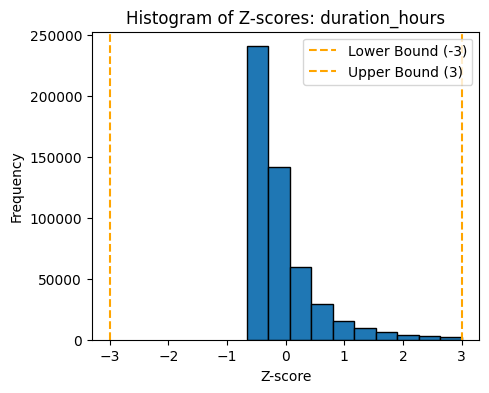

Medication_delays_hours
Count: 516431
Min: -4381.61666666667
Max: 184713.7
Mean: 18.81
Std: 703.87

Outliers:
Count: 5328
Min: 329853.383333333
Max: 8326692.95
Mean: 556549.31
Std: 464056.96


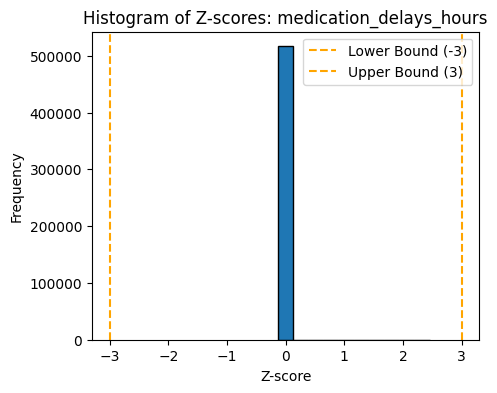

Medication_duration_hours
Count: 515456
Min: 0.0
Max: 207.366666666667
Mean: 11.54
Std: 26.58

Outliers:
Count: 6303
Min: 207.4
Max: 18549.3166666667
Mean: 392.96
Std: 367.35


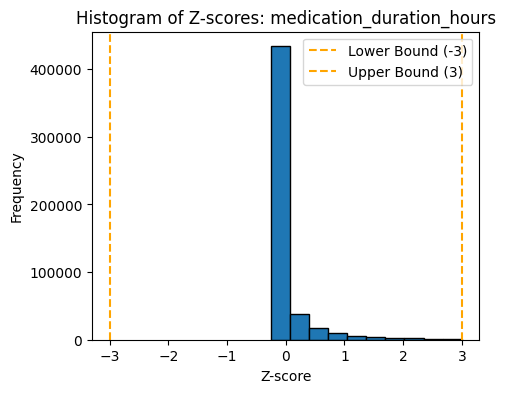

Max_bmi
Count: 83637
Min: 10.0
Max: 99.2
Mean: 28.44
Std: 7.27

Outliers:
Count: 313
Min: 0.0
Max: 126540.0
Mean: 2396.87
Std: 9759.69


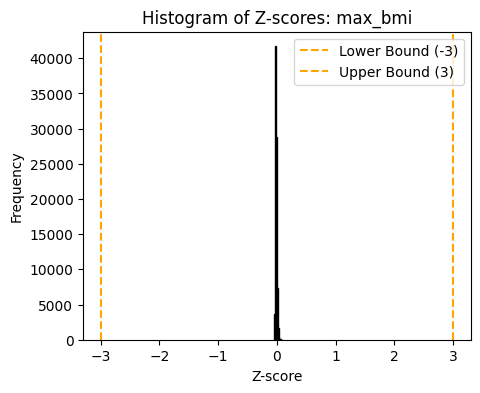

Min_bmi
Count: 83602
Min: 10.0
Max: 99.2
Mean: 28.36
Std: 7.25

Outliers:
Count: 348
Min: 0.0
Max: 126540.0
Mean: 2145.56
Std: 9278.77


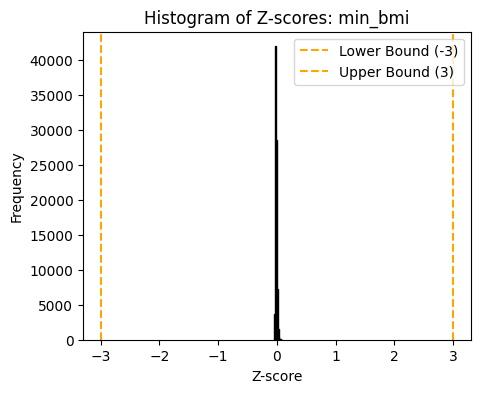

Height
Count: 83691
Min: 36.0
Max: 84.0
Mean: 66.1
Std: 4.24

Outliers:
Count: 259
Min: 0.0
Max: 73252.0
Mean: 522.16
Std: 4622.75


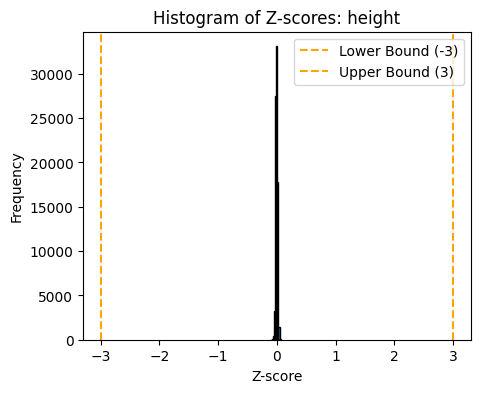

Weight
Count: 83870
Min: 50.0
Max: 736.99
Mean: 177.07
Std: 49.52

Outliers:
Count: 80
Min: 0.22
Max: 181580.69
Mean: 3325.82
Std: 20382.79


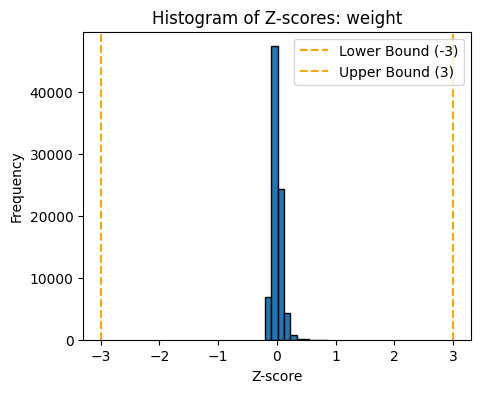

Sbp
Count: 44547
Min: 70
Max: 200
Mean: 126.36
Std: 20.34

Outliers:
Count: 239
Min: 40
Max: 250
Mean: 182.05
Std: 65.17


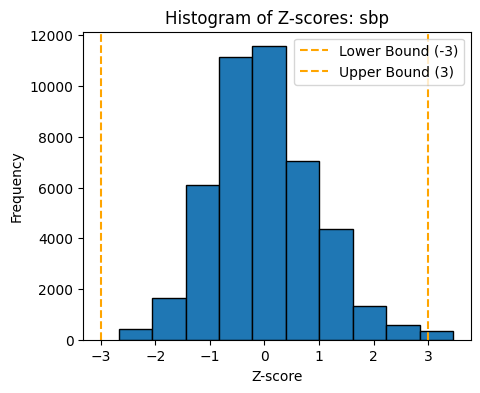

Dbp
Count: 44673
Min: 30
Max: 130
Mean: 73.6
Std: 13.28

Outliers:
Count: 113
Min: 0
Max: 199
Mean: 69.78
Std: 70.24


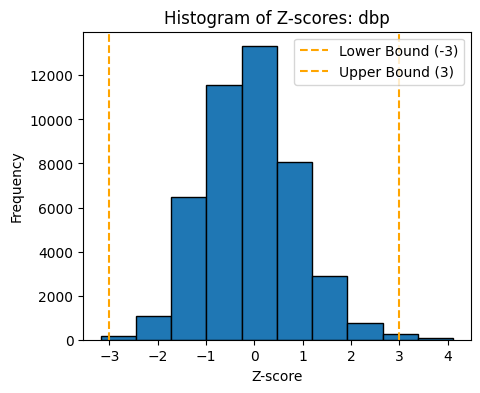

Map
Count: 44413
Min: 48.0
Max: 134.33
Mean: 90.98
Std: 13.57

Outliers:
Count: 373
Min: 13.33
Max: 203.67
Mean: 126.98
Std: 43.25


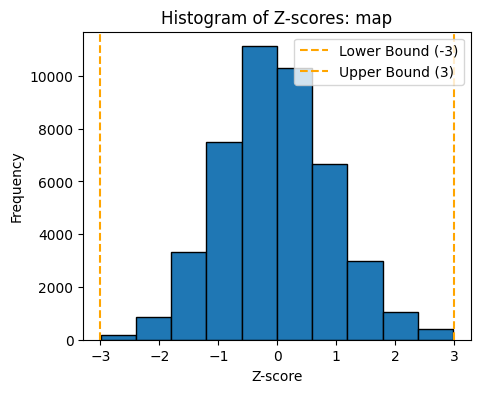

In [21]:
# these two are numeric but ordinal categorical features with no required processing
# 'drg_severity', 'drg_mortality'

# the list of numeric features for the Z-score analysis
numeric_features = ['procedure_count', 
                    'diagnoses_count', 
                    'medications_ordered', 
                    'medications_given',
                    'age', 
                    'duration_hours',
                    'medication_delays_hours',
                    'medication_duration_hours',
                    'max_bmi',
                    'min_bmi',
                    'height',
                    'weight',
                    'sbp',	
                    'dbp',	
                    'map'
                    ]


def remove_outliers(df, df_transformed, hide_process):
    # create a copy to store the Z-scores
    critical_care_zscores = df.copy(deep=True)
    
    # create a master mask to track rows to keep
    rows_to_keep = pd.Series(True, index=df_transformed.index)
    
    # init. lists for the special columns
    vital_columns = ['max_bmi', 'min_bmi', 'height', 'weight']
    
    blood_pressure_columns = ['sbp', 'dbp', 'map']
    
    # iterate through each feature, calculate the Z-scores for the current feature
    for col in numeric_features:

        # skip the current itertion if the col is not in the current DataFrame
        if col not in critical_care_zscores.columns:
            continue
    
        # calculate the Z-scores for the current col
        critical_care_zscores[col + '_z'] = stats.zscore(df[col])

        # remove all outleirs over 3 standard deviations
        all_outliers_mask = abs(critical_care_zscores[col + '_z']) > 3
        
        # 3 standard deviations is not appropraite for certain clinical features
        # none of these values should be zero
        # the values should be within 10 to 100
        if 'bmi' in col.lower():
            # BMI should be between 10 and 100, and not zero
            all_outliers_mask = (critical_care_zscores[col] < 10) | (critical_care_zscores[col] > 100)
        
        elif col.lower() == 'height':
            # height should be between 36 and 84 inches
            all_outliers_mask = (critical_care_zscores[col] > 84) | (critical_care_zscores[col] < 36)
            
        elif col.lower() == 'weight':
            # weight should be between 50 and 800 pounds
            all_outliers_mask = (critical_care_zscores[col] > 800) | (critical_care_zscores[col] < 50)
            
        elif col.lower() == 'sbp':
            # systolic blood pressure between 70 and 200 mmHg
            all_outliers_mask = (critical_care_zscores[col] < 70) | (critical_care_zscores[col] > 200)
            
        elif col.lower() == 'dbp':
            # diastolic blood pressure between 30 and 130 mmHg
            all_outliers_mask = (critical_care_zscores[col] < 30) | (critical_care_zscores[col] > 130)
            
        # outliers in map are captured by sbp/dbp outleirs since
        # those fetaures were used to calculate map
    
        # update the master mask to the keep rows that don't have outliers for this column
        rows_to_keep = rows_to_keep & ~all_outliers_mask

        # skip previously seen visualizations
        # only show visualizations for common columns once (from the main DataFrame)
        # else show special columns like vital signs and blood pressure columns only when processing their respective DataFrames
        if (hide_process == 0) & (col not in (vital_columns + blood_pressure_columns)):
            continue

        # print the statiscal properties of the column without extreme outliers
        print(col.capitalize())
        # does not inlcude outliers 
        print('Count:', len(critical_care_zscores[~all_outliers_mask]))
        print('Min:', critical_care_zscores[col][~all_outliers_mask].min())
        print('Max:', critical_care_zscores[col][~all_outliers_mask].max())
        print('Mean:', round(critical_care_zscores[col][~all_outliers_mask].mean(), 2))
        print('Std:', round(critical_care_zscores[col][~all_outliers_mask].std(), 2))

        # skip if no outliers
        if len(critical_care_zscores[all_outliers_mask]) > 0:
        # only the outliers
            print('\nOutliers:')
            print('Count:', len(critical_care_zscores[all_outliers_mask]))
            print('Min:', critical_care_zscores[col][all_outliers_mask].min())
            print('Max:', critical_care_zscores[col][all_outliers_mask].max())
            print('Mean:', round(critical_care_zscores[col][all_outliers_mask].mean(), 2))
            print('Std:', round(critical_care_zscores[col][all_outliers_mask].std(), 2))
        
        # plot the distribution of the Z-scores using a histogram
        plt.figure(figsize=(5, 4))
        plt.hist(critical_care_zscores[col + '_z'][~all_outliers_mask], edgecolor='k')
        
        plt.title('Histogram of Z-scores: ' + col)
        plt.xlabel('Z-score')
        plt.ylabel('Frequency')

        # draw boundaries at -3, 3, and 5
        plt.axvline(x=-3, color='orange', linestyle='--', label='Lower Bound (-3)')
        plt.axvline(x=3, color='orange', linestyle='--', label='Upper Bound (3)')
        
        plt.legend()
        plt.show()
    
    # apply the master mask to remove the outliers
    df_transformed = df_transformed[rows_to_keep]

    return df_transformed

# identify and remove the outleirs in all the DataFrames
critical_care_transformed_base = remove_outliers(critical_care_base, critical_care_transformed_base, 1)
critical_care_transformed_vitals = remove_outliers(critical_care_vitals, critical_care_transformed_vitals, 0)
critical_care_transformed_bp = remove_outliers(critical_care_bp, critical_care_transformed_bp, 0)
critical_care_transformed_pro = remove_outliers(critical_care_pro, critical_care_transformed_pro, 0)

In [22]:
# print the number of netries with outliers in each DataFrame
print("Base:", cct_entries - critical_care_transformed_base.shape[0])
print("Vitals:", ccv_entries - critical_care_transformed_vitals.shape[0])
print("Blood Pressure:", ccbp_entries - critical_care_transformed_bp.shape[0])
print("Procedures:", ccpro_entries - critical_care_transformed_pro.shape[0])

Base: 26640
Vitals: 5078
Blood Pressure: 2932
Procedures: 8847


In [23]:
# the distributions for the categorical variables will be shown for the primary DataFrame
# then it switches to the procedures DataFrame for when col is 'procedure_category'

# the categorical features are severly imbalanced

# for each categorical feature, print the distribution of the categories
for col in string_columns:
    if col != 'procedure_category':
        print('\n\t', critical_care_aggregated_base[col].value_counts())
    else:
        print('\n\t', critical_care_aggregated_pro[col].value_counts())

# these categories were dropped becuase they were extremely rare
critical_care_transformed_base.drop(["admission_location_INFORMATION NOT AVAILABLE", "insurance_No charge"], axis=1, inplace=True)
critical_care_transformed_vitals.drop(["admission_location_INFORMATION NOT AVAILABLE", "insurance_No charge"], axis=1, inplace=True)
critical_care_transformed_bp.drop(["admission_location_INFORMATION NOT AVAILABLE", "insurance_No charge"], axis=1, inplace=True)
critical_care_transformed_pro.drop(["admission_location_INFORMATION NOT AVAILABLE", "insurance_No charge"], axis=1, inplace=True)


	 admission_type
Urgent         241619
Observation    225584
Planned         54556
Name: count, dtype: int64

	 admission_location
EMERGENCY ROOM                   234080
Referrals                        211853
External Transfers                56912
Internal Procedural Transfers     18626
INFORMATION NOT AVAILABLE           288
Name: count, dtype: int64

	 insurance
Medicare     237678
Private      169052
Medicaid     101211
Other         13398
No charge       420
Name: count, dtype: int64

	 primary_language
English       471547
Other          23996
Spanish        17098
Chinese         7378
Vietnamese      1118
Arabic           622
Name: count, dtype: int64

	 marital_status
MARRIED     226186
SINGLE      199615
WIDOWED      56206
DIVORCED     39752
Name: count, dtype: int64

	 race
White              351226
Black               86765
Other               33722
Hispanic/Latino     30998
Asian               19048
Name: count, dtype: int64

	 first_service
Medical        356500
Surgical

# Split the Data for the Base Model

In [24]:
# extend the excluded features to remove irrelevant features
excluded_features.extend(['patient_id', 'admission_id', 'duration_hours'])

# get the set of intial features by subtracting the excluded set from the columns
initial_features = list(set(critical_care_transformed_base.columns) - set(excluded_features))

# reduced feature set with feature importance of > 0.01
# this was assessed separately and the results recorded below
# to avoid an additional 4 models
reduced_features = ['medication_delays_hours',
                     'drg_mortality',
                     'medications_given',
                     'admission_type_Planned',
                     'medication_duration_hours',
                     'first_service_PSYCH',
                     'admission_type_Urgent',
                     'age',
                     'diagnoses_count',
                     'procedure_count',
                     'drg_severity',
                     'medications_ordered']

# create X using the initial set of features
X = critical_care_transformed_base[initial_features]

# set y to duration in hours
y = critical_care_transformed_base["duration_hours"]

# split the data set into a 30/20 train/test sets
# ~148,000 train size
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3, test_size=0.2, random_state=42)

# Hyperparameter Tuning & Model Setup  
- Define hyperparameters for tuning  
- Perform GridSearch on Random Forest  
- Compare best vs. default hyperparameters  
- Initialize additional models  
- Split data, train models, and compute performance metrics
- Calculate the OOB RMSE and R-squared scores

In [25]:
# the parameters that will be tuned
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [None, 20],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4]
}

# initialize the GridSearch model
# negative MSE to minimize
# only 3 folds to reduce complexity
# add the max_features to all the models equal to the square root of the total features
# the default value is 100% of features and goes against the nature of random forest (leading to less diverse trees)
rf_cv = GridSearchCV(
    RandomForestRegressor(max_features='sqrt', random_state=42),
    param_grid=param_grid,
    cv=3,  
    scoring='neg_mean_squared_error',
    n_jobs=-1  
)

# perform grid search on the training set
rf_cv.fit(X_train, y_train)

# print the best model parameters
print("Best parameters:", rf_cv.best_params_)

# create a dict of the defualt values
default_params = {
    "max_depth": None,     
    "min_samples_split": 2,
    "min_samples_leaf": 1,
    "n_estimators": 100
}

# extract cv_results_
results = rf_cv.cv_results_

# find the index where default parameters match to compare the parameters and cv R-squaredrecall scores
for i, params in enumerate(results['params']):
    if params == default_params:

        print("\nDefault parameters:", default_params)

        # square root the MSE of the default model
        default_rmse = np.sqrt(-results['mean_test_score'][i])
        break

Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

Default parameters: {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 100}


In [26]:
# for the base model
# create the model and train it on the corresponding data
rf_base = RandomForestRegressor(**rf_cv.best_params_, random_state=42, oob_score=True)
rf_base.fit(X_train, y_train)

# get the predictions and calculate the RMSE for the test and train sets
y_pred = rf_base.predict(X_test)
test_rmse_base = np.sqrt(mean_squared_error(y_test, y_pred))

# for training RMSE
y_train_pred = rf_base.predict(X_train)
train_rmse_base = np.sqrt(mean_squared_error(y_train, y_train_pred))

# get the R-squared from the OOB
oob_rsquared_base = rf_base.oob_score_

# calculate the RMSE from the OOB
oob_predictions_base = rf_base.oob_prediction_
oob_rmse_base = np.sqrt(mean_squared_error(y_train, oob_predictions_base))

# do the same process for the following models

# reduced feature set with feature importance of > 0.01
# this was assessed separately and the results recorded below
# to avoid an additional 4 models

reduced_features_vitals = ['drg_mortality',
                             'max_bmi',
                             'min_bmi',
                             'medication_delays_hours',
                             'drg_severity',
                             'medication_duration_hours',
                             'height',
                             'medications_given',
                             'weight',
                             'first_service_PSYCH',
                             'age',
                             'admission_type_Urgent',
                             'diagnoses_count',
                             'procedure_count',
                             'medications_ordered']

reduced_features_bp = ['admission_location_Referrals',
                         'medications_given',
                         'admission_type_Urgent',
                         'admission_type_Planned',
                         'medication_duration_hours',
                         'drg_mortality',
                         'dbp',
                         'map',
                         'sbp',
                         'age',
                         'drg_severity',
                         'diagnoses_count',
                         'procedure_count',
                         'medications_ordered']

reduced_features_pro = ['marital_status_SINGLE',
                         'admission_location_Referrals',
                         'marital_status_MARRIED',
                         'procedure_category_10',
                         'procedure_category_18',
                         'gender_M',
                         'readmission_status',
                         'first_service_Surgical',
                         'medications_ordered',
                         'drg_mortality',
                         'admission_type_Urgent',
                         'admission_type_Planned',
                         'age',
                         'diagnoses_count',
                         'procedure_count',
                         'drg_severity']

# for vitals model

# prepare the data using full dataset
# vitals dataset includes limited admissions: 82,623
# 79,376 * 0.8 = 63,500 train size
initial_features_vitals = list(set(critical_care_transformed_vitals.columns) - set(excluded_features))
X_vitals = critical_care_transformed_vitals[initial_features_vitals]
y_vitals = critical_care_transformed_vitals["duration_hours"]
X_train_vitals, X_test_vitals, y_train_vitals, y_test_vitals = train_test_split(X_vitals, y_vitals, test_size=0.2, random_state=42)

# create and train the model
rf_vitals = RandomForestRegressor(**rf_cv.best_params_, random_state=42, oob_score=True)
rf_vitals.fit(X_train_vitals, y_train_vitals)

# calculate the performance metrics
y_pred_vitals = rf_vitals.predict(X_test_vitals)
test_rmse_vitals = np.sqrt(mean_squared_error(y_test_vitals, y_pred_vitals))
# for training RMSE
y_train_pred_vitals = rf_vitals.predict(X_train_vitals)
train_rmse_vitals = np.sqrt(mean_squared_error(y_train_vitals, y_train_pred_vitals))
oob_rsquared_vitals = rf_vitals.oob_score_
oob_predictions_vitals = rf_vitals.oob_prediction_
oob_rmse_vitals = np.sqrt(mean_squared_error(y_train_vitals, oob_predictions_vitals))

# for blood pressure model

# prepare the data using full dataset
# blood pressure dataset includes limited admissions: 47,067
# 41,792 * 0.8 = 33,433 train size
initial_features_bp = list(set(critical_care_transformed_bp.columns) - set(excluded_features))
X_bp = critical_care_transformed_bp[initial_features_bp]
y_bp = critical_care_transformed_bp["duration_hours"]
X_train_bp, X_test_bp, y_train_bp, y_test_bp = train_test_split(X_bp, y_bp, test_size=0.2, random_state=42)

# create and train the model 
rf_bp = RandomForestRegressor(**rf_cv.best_params_, random_state=42, oob_score=True)
rf_bp.fit(X_train_bp, y_train_bp)

# calculate the performance metrics
y_pred_bp = rf_bp.predict(X_test_bp)
test_rmse_bp = np.sqrt(mean_squared_error(y_test_bp, y_pred_bp))
# for training RMSE
y_train_pred_bp = rf_bp.predict(X_train_bp)
train_rmse_bp = np.sqrt(mean_squared_error(y_train_bp, y_train_pred_bp))
oob_rsquared_bp = rf_bp.oob_score_
oob_predictions_bp = rf_bp.oob_prediction_
oob_rmse_bp = np.sqrt(mean_squared_error(y_train_bp, oob_predictions_bp))

# for procedures model

# prepare the data using full dataset
# procedures dataset includes limited of admissions: 160313
# 149,472 * 0.8 = 119,577.6 train size
initial_features_pro = list(set(critical_care_transformed_pro.columns) - set(excluded_features))
X_pro = critical_care_transformed_pro[initial_features_pro]
y_pro = critical_care_transformed_pro["duration_hours"]
X_train_pro, X_test_pro, y_train_pro, y_test_pro = train_test_split(X_pro, y_pro, test_size=0.2, random_state=42)

# create and train the model 
rf_pro = RandomForestRegressor(**rf_cv.best_params_, random_state=42, oob_score=True)
rf_pro.fit(X_train_pro, y_train_pro)

# calculate the performance metrics
y_pred_pro = rf_pro.predict(X_test_pro)
test_rmse_pro = np.sqrt(mean_squared_error(y_test_pro, y_pred_pro))
# for training RMSE
y_train_pred_pro = rf_pro.predict(X_train_pro)
train_rmse_pro = np.sqrt(mean_squared_error(y_train_pro, y_train_pred_pro))
oob_rsquared_pro = rf_pro.oob_score_
oob_predictions_pro = rf_pro.oob_prediction_
oob_rmse_pro = np.sqrt(mean_squared_error(y_train_pro, oob_predictions_pro))

# Evaluate Model Performance  
- Print test set mean
- Calculate the R-squared scores for all the models
- Compare RMSE and R-squared scores across models  
- Visualize feature importances for models trained on different admission subsets
- Plot the actual vs. predicted values 

In [27]:
y_mean = np.mean(y_test)

# create an array of the same length as y_pred, filled with the mean value
baseline_predictions = np.full_like(y_pred, y_mean)

# calculate the RMSE for a model that predicts the average
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))

print('y_test mean:', y_mean)

y_test mean: 89.49368660930682


In [28]:
# the RMSE scores of the best and default model from the GridSearch
best_rmse = np.sqrt(-rf_cv.best_score_)
print("Grid Search RMSE comparison:")
print("Best Model RMSE score:", round(best_rmse, 2))
print("Default RMSE score:", round(default_rmse, 2))

# get the R-squared of all the models using test and training sets
test_rsquared_base = rf_base.score(X_test, y_test)
test_rsquared_vitals = rf_vitals.score(X_test_vitals, y_test_vitals)
test_rsquared_bp = rf_bp.score(X_test_bp, y_test_bp)
test_rsquared_pro = rf_pro.score(X_test_pro, y_test_pro)

train_rsquared_base = rf_base.score(X_train, y_train)
train_rsquared_vitals = rf_vitals.score(X_train_vitals, y_train_vitals)
train_rsquared_bp = rf_bp.score(X_train_bp, y_train_bp)
train_rsquared_pro = rf_pro.score(X_train_pro, y_train_pro)       

# RMSE scores comparison
print(f'\nBase RMSE scores: \n\tTrain: {train_rmse_base:.2f}\n\tTest: {test_rmse_base:.2f}\n\tOOB: {oob_rmse_base:.2f}')
print(f'Vitals RMSE scores: \n\tTrain: {train_rmse_vitals:.2f}\n\tTest: {test_rmse_vitals:.2f}\n\tOOB: {oob_rmse_vitals:.2f}')
print(f'Blood Pressure RMSE scores: \n\tTrain: {train_rmse_bp:.2f}\n\tTest: {test_rmse_bp:.2f}\n\tOOB: {oob_rmse_bp:.2f}')
print(f'Procedures RMSE scores: \n\tTrain: {train_rmse_pro:.2f}\n\tTest: {test_rmse_pro:.2f}\n\tOOB: {oob_rmse_pro:.2f}')

# R-squared scores comparison
print(f'\nBase R^2 scores: \n\tTrain: {train_rsquared_base:.2f}\n\tTest: {test_rsquared_base:.2f}\n\tOOB: {oob_rsquared_base:.2f}')
print(f'Vitals R^2 scores: \n\tTrain: {train_rsquared_vitals:.2f}\n\tTest: {test_rsquared_vitals:.2f}\n\tOOB: {oob_rsquared_vitals:.2f}')
print(f'Blood Pressure R^2 scores: \n\tTrain: {train_rsquared_bp:.2f}\n\tTest: {test_rsquared_bp:.2f}\n\tOOB: {oob_rsquared_bp:.2f}')
print(f'Procedures R^2 scores: \n\tTrain: {train_rsquared_pro:.2f}\n\tTest: {test_rsquared_pro:.2f}\n\tOOB: {oob_rsquared_pro:.2f}')

Grid Search RMSE comparison:
Best Model RMSE score: 51.88
Default RMSE score: 52.76

Base RMSE scores: 
	Train: 30.05
	Test: 52.23
	OOB: 52.37
Vitals RMSE scores: 
	Train: 21.61
	Test: 49.54
	OOB: 49.70
Blood Pressure RMSE scores: 
	Train: 27.65
	Test: 63.07
	OOB: 65.13
Procedures RMSE scores: 
	Train: 39.62
	Test: 71.24
	OOB: 69.77

Base R^2 scores: 
	Train: 0.89
	Test: 0.65
	OOB: 0.65
Vitals R^2 scores: 
	Train: 0.95
	Test: 0.72
	OOB: 0.72
Blood Pressure R^2 scores: 
	Train: 0.94
	Test: 0.66
	OOB: 0.66
Procedures R^2 scores: 
	Train: 0.83
	Test: 0.49
	OOB: 0.48


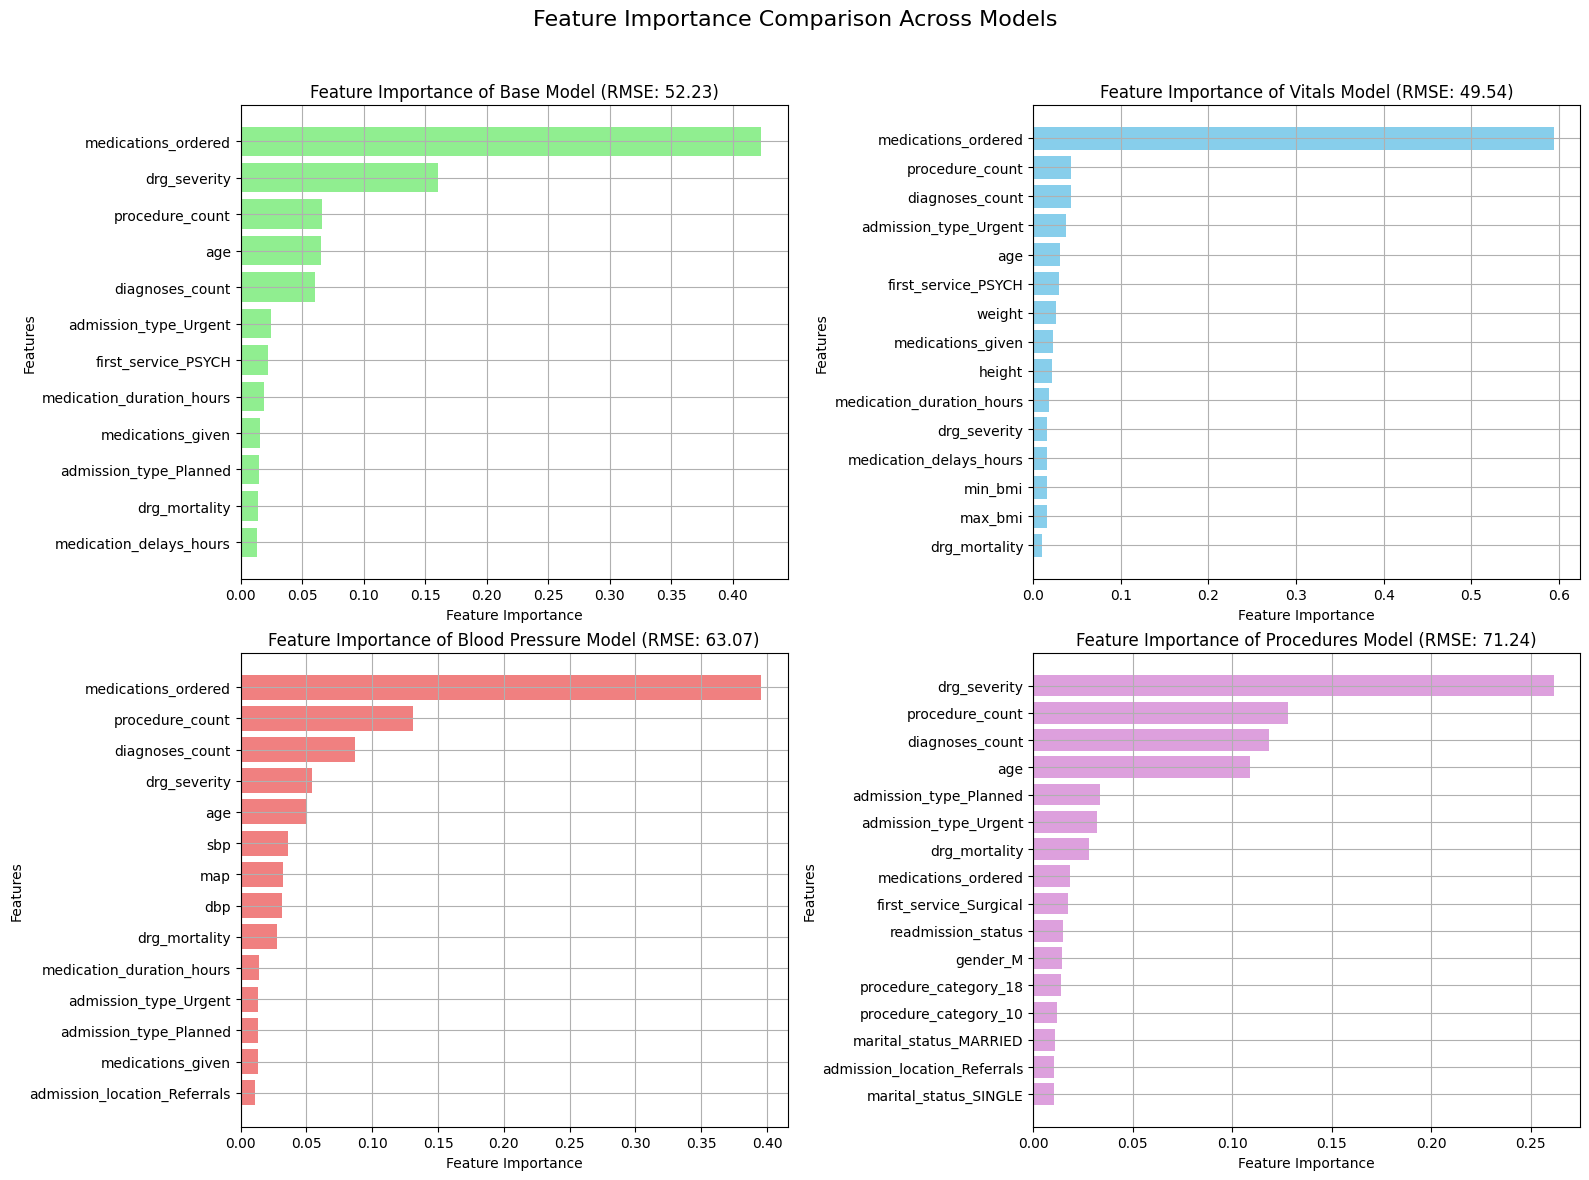

In [29]:
# set up a figure with 4 subplots in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# base model feature importance
importances_base = pd.Series(rf_base.feature_importances_, index=X.columns)
importances_base = importances_base[importances_base > 0.01]
sorted_importances_base = importances_base.sort_values()
axes[0, 0].barh(sorted_importances_base.index, sorted_importances_base.values, color="lightgreen")
axes[0, 0].set_xlabel("Feature Importance")
axes[0, 0].set_ylabel("Features")
axes[0, 0].set_title(f"Feature Importance of Base Model (RMSE: {test_rmse_base:.2f})")
axes[0, 0].grid()

# vitals model feature importance
importances_vitals = pd.Series(rf_vitals.feature_importances_, index=X_vitals.columns)
importances_vitals = importances_vitals[importances_vitals > 0.01]
sorted_importances_vitals = importances_vitals.sort_values()
axes[0, 1].barh(sorted_importances_vitals.index, sorted_importances_vitals.values, color="skyblue")
axes[0, 1].set_xlabel("Feature Importance")
axes[0, 1].set_ylabel("Features")
axes[0, 1].set_title(f"Feature Importance of Vitals Model (RMSE: {test_rmse_vitals:.2f})")
axes[0, 1].grid()

# blood pressure model feature importance
importances_bp = pd.Series(rf_bp.feature_importances_, index=X_bp.columns)
importances_bp = importances_bp[importances_bp > 0.01]
sorted_importances_bp = importances_bp.sort_values()
axes[1, 0].barh(sorted_importances_bp.index, sorted_importances_bp.values, color="lightcoral")
axes[1, 0].set_xlabel("Feature Importance")
axes[1, 0].set_ylabel("Features")
axes[1, 0].set_title(f"Feature Importance of Blood Pressure Model (RMSE: {test_rmse_bp:.2f})")
axes[1, 0].grid()

# procedures model feature importance
importances_pro = pd.Series(rf_pro.feature_importances_, index=X_pro.columns)
importances_pro = importances_pro[importances_pro > 0.01]
sorted_importances_pro = importances_pro.sort_values()
axes[1, 1].barh(sorted_importances_pro.index, sorted_importances_pro.values, color="plum")
axes[1, 1].set_xlabel("Feature Importance")
axes[1, 1].set_ylabel("Features")
axes[1, 1].set_title(f"Feature Importance of Procedures Model (RMSE: {test_rmse_pro:.2f})")
axes[1, 1].grid()

# adjust layout 
plt.tight_layout()

# leave room for a title
plt.subplots_adjust(top=0.9)
fig.suptitle("Feature Importance Comparison Across Models", fontsize=16)

plt.show()

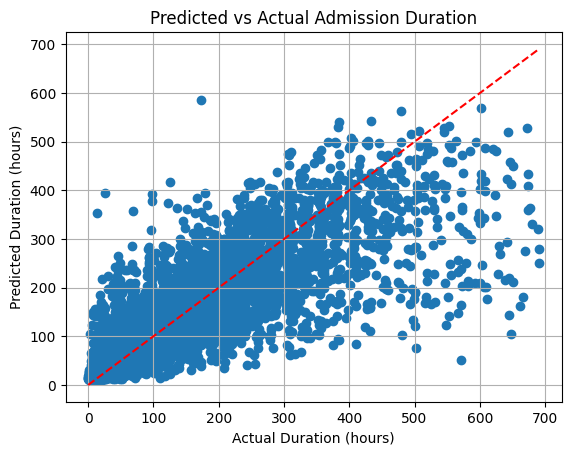

In [30]:
# plot the actual vs. prediction values for the vitals model (optimal model based on lowest RMSE)
plt.scatter(y_test_vitals, y_pred_vitals)

# add the perfect prediction line
plt.plot([0, max(y_test_vitals)], [0, max(y_test_vitals)], color='red', linestyle='--')

# add title and labels
plt.title("Predicted vs Actual Admission Duration")
plt.xlabel("Actual Duration (hours)")
plt.ylabel("Predicted Duration (hours)")
plt.grid(True)

plt.show()

# Results
Data Subset Shapes
- Base: (544190, 26)
- Vitals: (89669, 30)
- Blood Pressure: (48928, 29)
- Procedures: (162992, 27)

Duplicates
- Base: 10
- Vitals: 1,868
- Blood Pressure: 3,730
- Procedures: 1

Missing Values
- Base: 
    - Admission Location: 1
    - Insurance: 9,328
    - Primary Language: 767
	- Marital Status: 13,566
- Vitals:
    - Insurance: 1,289
    - Primary Language: 27
    - Marital Status: 2,672
- Blood Pressure:
    - Insurance: 177
    - Primary Language: 5
    - Marital Status: 231
- Procedures:
    - Insurance: 2,318
    - Primary Language: 513
    - Marital Status: 3,477

Aggregated Categorical features:
- Race, Primary Language, First Service, Admission Type/Location

One-Hot Encoding Transformation number of columns
- Base: 26 => 45
- Vitals: 30 => 49
- Blood Pressure: 29 => 48
- Procedures: 27 => 61

Outliers
- Procedure_count: 10,928
- Diagnoses_count: 6,479
- Medications_ordered: 7,674
- Medications_given: 7,651
- Duration_hours: 9,159
- Medication_delays_hours: 5,328
- Medication_duration_hours: 6,303
- Max_bmi: 313
- Min_bmi: 348
- Height: 259
- Weight: 80
- Sbp: 239
- Dpb: 113
- Map: 373

The number of entries with outliers in each DataFrame
- Base: 26,640
- Vitals: 5,078
- Blood Pressure: 2,932
- Procedures: 8,847 

Categorical Features: Severely imbalanced categories across all categorical features except gender.

Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}

No further improvements in performance when model complexity is increased.

Final Train Sizes:
- Base:(148960, 35)
- Vitals: (63291, 39)
- Blood Pressure: (33564, 38)
- Procedures: (119577, 51)

Y_test mean: ~90

Initial Feature Set Performance

    Grid Search RMSE comparison:
    Best Model RMSE score: 51.9
    Default RMSE score: 52.77

    Base RMSE scores: 
    	Train: 30.06
    	Test: 52.24
    	OOB: 52.39
    Vitals RMSE scores: 
    	Train: 21.60
    	Test: 49.55
    	OOB: 49.69
    Blood Pressure RMSE scores: 
    	Train: 27.65
    	Test: 63.10
    	OOB: 65.13
    Procedures RMSE scores: 
    	Train: 39.62
    	Test: 71.25
    	OOB: 69.75
        
    Base R^2 scores: 
    	Train: 0.89
    	Test: 0.65
    	OOB: 0.654
    Vitals R^2 scores: 
    	Train: 0.95
    	Test: 0.72
    	OOB: 0.73
    Blood Pressure R^2 scores: 
    	Train: 0.94
    	Test: 0.66
    	OOB: 0.66
    Procedures R^2 scores: 
    	Train: 0.83
    	Test: 0.49
    	OOB: 0.48

Reduced Feature Set Results

    Grid Search RMSE comparison:
    Best Model RMSE score: 52.42
    Default RMSE score: 56.11

    # Note: In the reduced set, tuning hyperparameters led to a significantly larger performance improvement compared to the default model.
    
    Base RMSE scores: 
    	Train: 41.72
    	Test: 53.10
    	OOB: 53.14
    Vitals RMSE scores: 
    	Train: 33.64
    	Test: 50.90
    	OOB: 50.83
    Blood Pressure RMSE scores: 
    	Train: 44.88
    	Test: 63.69
    	OOB: 65.94
    Procedures RMSE scores: 
    	Train: 53.58
    	Test: 72.75
    	OOB: 70.84
    
    Base R^2 scores: 
    	Train: 0.78
    	Test: 0.64
    	OOB: 0.64
    Vitals R^2 scores: 
    	Train: 0.87
    	Test: 0.71
    	OOB: 0.71
    Blood Pressure R^2 scores: 
    	Train: 0.84
    	Test: 0.66
    	OOB: 0.65
    Procedures R^2 scores: 
    	Train: 0.70
    	Test: 0.47
    	OOB: 0.47

Top 5 Features Per Model (Initial Set)

- Base
    - medications_ordered          0.423407
    - drg_severity                 0.160315
    - procedure_count              0.066195
    - age                          0.064985
    - diagnoses_count              0.060545

- Vitals
    - medications_ordered          0.594531
    - procedure_count              0.043572
    - diagnoses_count              0.042604
    - admission_type_Urgent        0.037615
    - age                          0.030932

- Blood Pressure
    - medications_ordered             0.395600
    - procedure_count                 0.130912
    - diagnoses_count                 0.086542
    - drg_severity                    0.054883
    - age                             0.049796

- Procedures
    - drg_severity                    0.261678
    - procedure_count                 0.128036
    - diagnoses_count                 0.118748
    - age                             0.108902
    - admission_type_Planned          0.033519

Top 5 Features Per Model (Reduced Set)

- Base
    - medications_ordered          0.483106
    - drg_severity                 0.183324
    - procedure_count              0.072953
    - age                          0.069859
    - diagnoses_count              0.062843
      
- Vitals
    - medications_ordered          0.658252
    - diagnoses_count              0.049623
    - admission_type_Urgent        0.041777
    - procedure_count              0.037023
    - age                          0.034817

- Blood Pressure
    - medications_ordered             0.453649
    - procedure_count                 0.147917
    - diagnoses_count                 0.093039
    - drg_severity                    0.063299
    - age                             0.051225

- Procedures
    - drg_severity                    0.318748
    - procedure_count                 0.151640
    - diagnoses_count                 0.135867
    - age                             0.127858
    - admission_type_Planned          0.040241